In [5]:
 # %pip install robin_stocks openai==1.2.2 yfinance requests_oauthlib twilio boto3 --upgrade 

In [2]:
import robin_stocks.robinhood as r
import requests
import json
import pandas as pd
import datetime
from dateutil import parser
from dateutil.relativedelta import relativedelta
from datetime import timedelta
import boto3
from tqdm.auto import tqdm

In [3]:
from twilio.rest import Client

In [4]:
from news2roi import News2ROI

In [5]:
s3 = boto3.client('s3')

In [6]:
bucket_name = 'jvalansi-notebooks-data'

In [11]:
# j = json.load(open("/root/.aws/secrets.json"))

In [12]:
# s3.upload_file("/root/.aws/secrets.json", bucket_name, ".aws.json")

In [13]:
# s3.upload_file("/root/.rapidapi.json", bucket_name, ".rapidapi.json")

In [7]:
data = s3.get_object(Bucket=bucket_name, Key=".aws.json")
j = json.loads(data['Body'].read().decode('utf8'))
openai_key = j['OPENAI_KEY']
data = s3.get_object(Bucket=bucket_name, Key=".rapidapi.json")
j = json.loads(data['Body'].read().decode('utf8'))
rapidapi_key = j["key"]


In [8]:
n2r = News2ROI(openai_key, rapidapi_key)

In [9]:
# s3.upload_file("/root/.robinhood.json", bucket_name, ".robinhood.json")

In [10]:
data = s3.get_object(Bucket=bucket_name, Key=".robinhood.json")

In [11]:
j = json.loads(data['Body'].read().decode('utf8'))
login = r.login(j["user"],j["pass"])

In [12]:
my_stocks = r.build_holdings()

In [47]:
for key,value in my_stocks.items():
    print(key,value)

VT {'price': '102.460000', 'quantity': '600.00000000', 'average_buy_price': '100.2850', 'equity': '61476.00', 'percent_change': '2.17', 'intraday_percent_change': '0.00', 'equity_change': '1305.000000', 'type': 'etp', 'name': 'Vanguard Total World Stock ETF', 'id': '0a5a879a-d527-45f7-94f6-be3370f22e77', 'pe_ratio': '16.829790', 'percentage': '44.04'}
BRK.B {'price': '363.000000', 'quantity': '50.00000000', 'average_buy_price': '205.0000', 'equity': '18150.00', 'percent_change': '77.07', 'intraday_percent_change': '0.00', 'equity_change': '7900.000000', 'type': 'stock', 'name': 'Berkshire Hathaway', 'id': 'a4f0cca4-79dc-4297-9c02-5bce1909cd4b', 'pe_ratio': '10.341900', 'percentage': '13.00'}
BEAM {'price': '25.440000', 'quantity': '26.00000000', 'average_buy_price': '27.8500', 'equity': '661.44', 'percent_change': '-8.65', 'intraday_percent_change': '0.00', 'equity_change': '-62.660000', 'type': 'stock', 'name': 'Beam Therapeutics', 'id': '267a182c-f42b-493a-8e3d-4019685fe400', 'pe_rat

In [73]:
# os.mkdir('data/reuters')

In [ ]:
# every half an hour:


In [13]:
r = requests.get("https://newsapi.org/v2/top-headlines?country=us&apiKey=f00a072ea8894dacaf9c1cc1dff332ab")

In [14]:
j = r.json()

In [20]:
j['articles']

[{'source': {'id': None, 'name': 'CNBC'},
  'author': 'Brian Evans',
  'title': 'Stock futures climb as Wall Street looks for S&P 500 to build on fresh all-time high: Live updates - CNBC',
  'description': 'Stocks officially entered bull market territory on Friday.',
  'url': 'https://www.cnbc.com/2024/01/21/stock-futures-tk-wall-street-looks-to-extend-bull-market-run.html',
  'urlToImage': 'https://image.cnbcfm.com/api/v1/image/107140651-1666731621929-NYSE-Traders-OB-20221025-CC-PRESS-3.jpg?v=1669836338&w=1920&h=1080',
  'publishedAt': '2024-01-22T05:52:00Z',
  'content': "Stock futures rose on Sunday evening, with investors looking to build on the S&amp;P 500's fresh all-time high from Friday.\r\nFutures tied to the benchmark S&amp;P 500 added 0.21%, while Nasdaq 100 fu… [+1564 chars]"},
 {'source': {'id': None, 'name': 'Sports Illustrated'},
  'author': 'Karl Rasmussen',
  'title': "Chiefs Lineman Claims Bills Shut Off Hot Water in Kansas City's Locker Room After Playoff Clash - Spo

In [13]:
date = datetime.datetime.today().strftime('%Y-%m-%d')

In [11]:
date = "2024-01-16"

In [14]:
# get new news articles
news = n2r.get_news(date)

In [15]:
len(news)

1

In [38]:
news = [article for article in news if News2ROI.contains_words(article, words={'United States',"US"})]

In [70]:
news = [article for article in news if News2ROI.is_recent(article['publishedAt']['date'], delta=datetime.timedelta(days=5, hours=1))]

In [71]:
len(news_)

34

In [72]:
# get sentiment
res = []


In [ ]:
for article in tqdm(us_news):
    res += [n2r.analyse_article(article, date)]
    

  0%|          | 0/44 [00:00<?, ?it/s]

In [75]:
res = list(filter(None,res))

In [76]:
# for low sentiment articles
df = pd.DataFrame(res)


In [77]:
df.to_csv(f"data/reuters/{date}.tsv", sep='\t')

In [78]:
df = pd.read_csv(f"data/reuters/{date}.tsv", sep='\t',index_col=0)

In [79]:
df['action'] = pd.to_numeric(df['action'], errors='coerce')

In [80]:
low = df[df['action']<=3]

In [81]:
low

,stock,ticker,reasoning,action,date,data
2,Futures Index ETF,SPY,The hawkish remarks from central bankers sugge...,3,2024-01-16,"Stocks slide, dollar gains on rates outlook ji..."
9,Sony Group Corporation,SONY,Despite the Tokyo Stock Exchange's initiative ...,3,2024-01-16,Japan Inc&#8217;s value boost plan lacks key e...
16,Invesco CurrencyShares British Pound Sterling ...,FXB,The Invesco CurrencyShares British Pound Sterl...,3,2024-01-16,Sterling slips after UK wage growth slows shar...
32,Newmont Corporation,NEM,"As the largest gold mining company, Newmont Co...",3,2024-01-16,"Gold retreats as US dollar, yields climb; Fed ..."


In [44]:
# ticker = low_sentiment.iloc[0]['ticker']

In [82]:
ticker = df.sort_values('action').iloc[0]['ticker']

In [83]:
ticker

'SPY'

In [ ]:
# get options


In [ ]:
# expirationDate = the next friday

In [48]:
today = datetime.date.today()

In [49]:
days_till_next_friday = (4-today.weekday()) % 7
if not days_till_next_friday:
    days_till_next_friday = 7

In [50]:
friday = today + datetime.timedelta( days_till_next_friday )


In [51]:
friday_s = friday.strftime("%Y-%m-%d")

In [52]:
optionData = r.find_options_by_expiration([ticker], expirationDate=friday_s,optionType='put')

Loading Market Data Loading Market Data Loading Market Data Loading Market Data Loading Market Data Loading Market Data Loading Market Data Loading Market Data Loading Market Data Loading Market Data Loading Market Data Loading Market Data Loading Market Data Loading Market Data Loading Market Data Loading Market Data Loading Market Data Loading Market Data Loading Market Data Loading Market Data Loading Market Data Loading Market Data Loading Market Data Loading Market Data Loading Market Data Loading Market Data Loading Market Data Loading Market Data Loading Market Data Loading Market Data Loading Market Data Loading Market Data Loading Market Data Loading Market Data Loading Market Data Loading Market Data Loading Market Data Loading Market Data Loading Market Data Loading Market Data Loading Market Data Loading Market Data Loading Market Data Loading Market Data Loading Market Data Loading Market Data Loading Market Data Loading Market Data Loading Market Data Loading Market Data 

In [53]:
len(optionData)

96

In [79]:
option_df = pd.DataFrame(optionData)

In [55]:
option_df.columns

Index(['chain_id', 'chain_symbol', 'created_at', 'expiration_date', 'id',
       'issue_date', 'min_ticks', 'rhs_tradability', 'state', 'strike_price',
       'tradability', 'type', 'updated_at', 'url', 'sellout_datetime',
       'long_strategy_code', 'short_strategy_code', 'adjusted_mark_price',
       'adjusted_mark_price_round_down', 'ask_price', 'ask_size', 'bid_price',
       'bid_size', 'break_even_price', 'high_price', 'instrument',
       'instrument_id', 'last_trade_price', 'last_trade_size', 'low_price',
       'mark_price', 'open_interest', 'previous_close_date',
       'previous_close_price', 'volume', 'symbol', 'occ_symbol',
       'chance_of_profit_long', 'chance_of_profit_short', 'delta', 'gamma',
       'implied_volatility', 'rho', 'theta', 'vega', 'pricing_model',
       'high_fill_rate_buy_price', 'high_fill_rate_sell_price',
       'low_fill_rate_buy_price', 'low_fill_rate_sell_price'],
      dtype='object')

In [80]:
option_df['strike_price'] = pd.to_numeric(option_df['strike_price'])

In [81]:
option_df['adjusted_mark_price'] = pd.to_numeric(option_df['adjusted_mark_price'])

In [82]:
option_df['break_even_price'] = pd.to_numeric(option_df['break_even_price'])

In [83]:
option_df = option_df.sort_values('strike_price')

In [84]:
# option_df = option_df[option_df['volume']>0]

In [96]:
option_df = option_df[option_df['strike_price']>220]

In [86]:
option_df = option_df[option_df['strike_price']<300]

In [87]:
current_price = max(option_df['break_even_price'])

In [88]:
current_price

248.52

In [98]:
option_df[['type','strike_price','adjusted_mark_price','break_even_price', 'volume', 'chance_of_profit_long']].sort_values('strike_price')

,type,strike_price,adjusted_mark_price,break_even_price,volume,chance_of_profit_long
41,put,222.5,0.36,222.14,2334,0.054069
83,put,225.0,0.49,224.51,9282,0.069726
81,put,227.5,0.67,226.83,6601,0.089308
55,put,230.0,0.91,229.09,17359,0.112767
86,put,232.5,1.22,231.28,5755,0.139704
58,put,235.0,1.63,233.37,12739,0.170499
60,put,237.5,2.17,235.33,8908,0.204508
43,put,240.0,2.82,237.18,27019,0.239272
49,put,242.5,3.63,238.87,9097,0.274667
61,put,245.0,4.60,240.40,19297,0.309001


<AxesSubplot:xlabel='strike_price'>

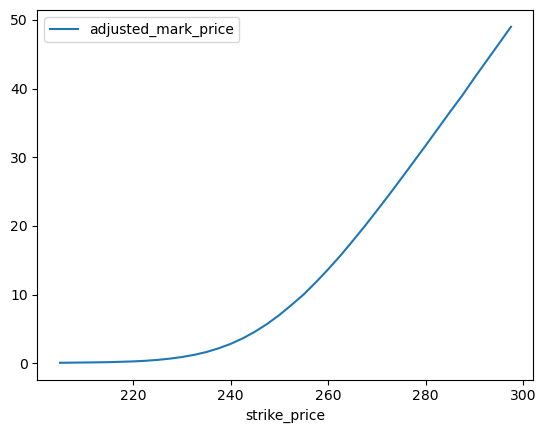

In [90]:
option_df.plot(x='strike_price', y='adjusted_mark_price')

<AxesSubplot:xlabel='strike_price'>

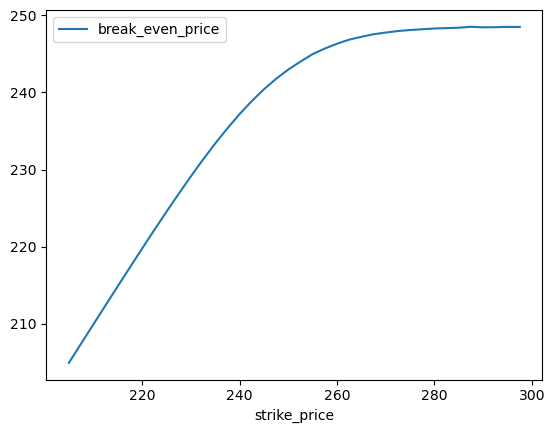

In [91]:
option_df.plot(x='strike_price', y='break_even_price')

In [ ]:
# find lowest option price with highest break even price
# usually the current stock price
# example stock costs 100
# option to put (sell) in a week for 100 costs 1$
# if the stock costs 99 in a week, I break even, anything below I earn
# e.g if the stock costs 98 in a week, I sell at 100, I get 2$, but it cost 1$, I made 1$

# if I buy the option to sell in 150, it costs 49.85
# if the stock costs 100 in a week, I sell at 150, I made 50, but it cost me 49.85, I made 0.15$

# if I buy the option to sell in 90, it costs 0.02
# if the stock costs 100 in a week, I sell in 90, I lost 10$

# options are at a multiples of 100s
# so if the stock costs 100
# and costs 4 to sell at 104
# if the stock goes to 101, it'll cost 3, so I could sell at 3$ and lose 100
# I could lose everythin
# If it goes to 99, it'll cost 5, and I could sell at 5, and gain 100
# I could 

In [74]:
# I want to maximize ROI
# I need to check which one maximizes for the expected value of 0.2% drop

In [77]:
target_price = current_price*(1-0.02)

In [ ]:
# when the target price hits, the option prices should shift with the target price
# say current price is 100

In [ ]:
# maybe easier to calculate - each price shifts one up

In [97]:
option_df['adjusted_mark_price'].diff()/option_df['adjusted_mark_price']

41         NaN
83    0.265306
81    0.268657
55    0.263736
86    0.254098
58    0.251534
60    0.248848
43    0.230496
49    0.223140
61    0.210870
9     0.197208
21    0.184922
18    0.172941
71    0.152542
93    0.150000
50    0.137427
28    0.125879
57    0.119798
40    0.108772
79    0.102564
70    0.093763
29    0.088104
48    0.081911
72    0.075710
27    0.071742
31    0.066940
82    0.061057
76    0.061853
69    0.056325
12    0.053118
11    0.051020
Name: adjusted_mark_price, dtype: float64

In [ ]:
# place option for the day
r.order_buy_option_limit

In [ ]:
# place reminder to sell tomorrow


In [ ]:
# sell previous reminders


In [141]:
print(low.iloc[0].to_json(indent=2))

{
  "stock":"Astellas Pharma Inc.",
  "ticker":"ALPMY",
  "reasoning":"The FDA's decision not to approve Astellas Pharma's experimental gastric cancer drug represents a significant setback for the company, as the U.S. market is substantial for pharmaceutical companies. This will likely result in delays to any potential revenue from this drug as the issues cited require resolution and potentially a resubmission for approval. Investors often react negatively to such news, and the stock could face short-term pressure due to the uncertainty and potential impact on future revenue streams.",
  "action":3,
  "date":"2024-01-09",
  "data":"US FDA declines to approve Astellas' gastric cancer drug - Japan's Astellas Pharma said on Monday the U.S. Food and Drug Administration (FDA) has declined to approve its experimental drug to treat a type of gastric cancer, citing issues related to a third-party manufacturer."
}


In [15]:
j = {'account_sid': 'AC417be496c2958add9742abcc83840cb7',
     'auth_token': '32e6cee11411c6037525b250c973eb2f',
     'from': 'whatsapp:+14155238886',
     'to': 'whatsapp:+14083862927'}


In [43]:
# with open('/root/.twilio.json', 'w') as f:
#     f.write(json.dumps(j))

In [44]:
# s3.upload_file("/root/.twilio.json", bucket_name, ".twilio.json")

In [45]:
data = s3.get_object(Bucket=bucket_name, Key=".twilio.json")

In [46]:
j = json.loads(data['Body'].read().decode('utf8'))

In [38]:
account_sid = j['account_sid']
auth_token = j['auth_token']
client = Client(account_sid, auth_token)

message = client.messages.create(
  from_=j['from'],
  body=low.iloc[0].to_json(indent=2),
  to=j['to']
)

print(message.sid)

SMbc1e47ef100d8a8d8f0e31bcbaae0310
